In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img, norm):
    """
    :param img: (PyTorch Tensor)
    """
    if norm:
        # unnormalize
        img = img / 2 + 0.5    
        
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_image(img):
    """
    convert a tensor to images suitable for plotting
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    return np.transpose(npimg, (1, 2, 0))

def plot_loss_acc(train_loss, val_loss, train_acc, val_acc):
    x = np.arange(1, len(train_loss) + 1)

    fig,axs = plt.subplots(1, 2, figsize=(16,6))
    axs[0].plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    axs[0].plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    axs[0].set_title("Evolution of the training, validation and test loss")

    axs[1].plot(x, train_acc, color=colors[0], label="Training accuracy", linewidth=2)
    axs[1].plot(x, val_acc, color=colors[1], label="Validation accuracy", linewidth=2)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    axs[1].set_title("Evolution of the training, validation and test accuracy")
    plt.show()
    

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

def plot_pvals(pvals, labels):
    idx_in = np.where(labels==0)[0]
    idx_out = np.where(labels==1)[0]

    pvals_in = np.array(pvals)[idx_in]
    pvals_out = np.array(pvals)[idx_out]

    plt.figure(figsize=(8,6))
    plt.hist(pvals_in, bins=100, alpha=0.5, label="inliers")
    plt.hist(pvals_out, bins=100, alpha=0.5, label="outliers")
    plt.legend()
    plt.show

    print('Average p-value for inliers is {:3f}, average p-value for outliers is {:3f}.'\
          .format(np.mean(pvals_in), np.mean(pvals_out)))

In [3]:
import torch as th
from tqdm import tqdm
import torchvision
import sys, os
import pandas as pd
from torchvision import transforms
from torchvision import datasets

sys.path.append('../ConformalizedES')
sys.path.append('../third_party')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Experiment: Compare with the naive benchmark

### Load MNIST dataset

In [4]:
# Download the MNIST Dataset
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize(mean=0.5, std=0.5)])

transform = transforms.Compose(
    [transforms.ToTensor()])

train_set_full = datasets.MNIST(root = "./data", train = True, download = True, transform=transform)
test_set_full = datasets.MNIST(root = "./data", train = False, download = True, transform=transform)

In [5]:
from datasetMaker import get_class_i, DatasetMaker

x_train_full = train_set_full.data
y_train_full = train_set_full.targets
x_test_full = test_set_full.data
y_test_full = test_set_full.targets

# Train set composed only of number 0
train_set = \
    DatasetMaker(
        [get_class_i(x_train_full, y_train_full, 0)]
    )

# Test set is a mixture of number 0 and 8
test_set = \
    DatasetMaker(
        [get_class_i(x_test_full, y_test_full, 0),
        get_class_i(x_test_full, y_test_full, 8),
]
    )

print('total number of available training data is: {:d}.'.format(len(train_set)))
print('total number of test data is {:d} in which {:d} are label 0 test data, {:d} are label 8 test data.'\
      .format(len(test_set), test_set.lengths[0],test_set.lengths[1]))

total number of available training data is: 5923.
total number of test data is 1954 in which 980 are label 0 test data, 974 are label 8 test data.


### Benchmark data-splitting vs CES data-splitting

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

def split_data(seed, n_train_bm, n_val_bm, n_cal_bm, batch_size=10, num_workers=0):
    np.random.seed(seed)
    th.manual_seed(seed)

    # MNIST is a simple dataset, hence we only take 300 inlier data to demonstrate
    # Benchmark data splitting: equally split the data into 3 sets
    n_full = len(train_set)
    n_data = n_train_bm + n_val_bm + n_cal_bm

    train_set_bm, val_set_bm, cal_set_bm, _ = th.utils.data.random_split(train_set,\
                                     [n_train_bm, n_val_bm, n_cal_bm, n_full-n_data])

    # CES data splitting: calibration set is not needed, merge back to the training set
    n_train_ces = n_train_bm + n_val_bm
    n_val_ces = n_cal_bm

    train_set_ces, val_set_ces, _ = th.utils.data.random_split(train_set,\
                                     [n_train_ces, n_val_ces, n_full-n_data])
    
    train_loader_bm = th.utils.data.DataLoader(train_set_bm, batch_size=batch_size,
                                          num_workers=num_workers)

    val_loader_bm = th.utils.data.DataLoader(val_set_bm, batch_size=n_val_bm,
                                              num_workers=num_workers)

    cal_loader_bm = th.utils.data.DataLoader(cal_set_bm, batch_size=n_cal_bm,
                                              num_workers=num_workers)

    # For CES
    train_loader_ces = th.utils.data.DataLoader(train_set_ces, batch_size=batch_size,
                                              num_workers=num_workers)

    val_loader_ces = th.utils.data.DataLoader(val_set_ces, batch_size=n_val_ces,
                                              num_workers=num_workers)
    return train_loader_bm, val_loader_bm, cal_loader_bm, train_loader_ces, val_loader_ces

def load_test(seed, n_test, num_workers=0):
    np.random.seed(seed)
    th.manual_seed(seed)

    test_sampler = SubsetRandomSampler(np.arange(n_test, dtype=np.int64))
    test_loader = th.utils.data.DataLoader(test_set, batch_size=n_test, sampler=test_sampler,
                                             num_workers=num_workers)

    # get all test images
    dataiter = iter(test_loader)
    inputs, labels = dataiter.next()
    return inputs, labels

## Define experiment

In [7]:
from method import CES_oneClass
from networks import ConvAutoencoder
from utils import eval_pvalues
import torch.optim as optim
from inference import Conformal_PVals


def run_experiment(seed, n_train_bm, n_val_bm, n_cal_bm, n_test, lr, n_epoch, alpha_list, batch_size=10, num_worker=0, visualize=True):
    # Initialize result data frame
    results = pd.DataFrame({})
    
    # Get the dataloaders and test points
    train_loader_bm, val_loader_bm, cal_loader_bm, train_loader_ces, val_loader_ces =\
    split_data(seed, n_train_bm, n_val_bm, n_cal_bm, batch_size, num_worker)
    inputs, labels = load_test(seed, n_test)
    
    
    # Define default device, we should use the GPU (cuda) if available
    device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)
    if th.cuda.is_available():
        # Make CuDNN Determinist
        th.backends.cudnn.deterministic = True
        th.cuda.manual_seed(seed)
    # Set the NN parameters 
    net_bm = ConvAutoencoder()
    Loss = th.nn.MSELoss()
    def criterion(outputs, inputs, targets):
        return Loss(outputs, inputs)
    optimizer_bm = optim.Adam(net_bm.parameters(), lr=lr)
    
    
    np.random.seed(seed)
    th.manual_seed(seed)
    
    # Train with benchmark data splitting
    print("Training with standard data splitting...")
    sys.stdout.flush()
    
    CES_oc_bm = CES_oneClass(net_bm, device, train_loader_bm, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_bm, criterion=criterion,optimizer=optimizer_bm)
    CES_oc_bm.full_train(save_dir = './models/oneClass/exp'+str(seed)+'/benchmarks/', save_every = 1)
    
    if visualize:
        plot_loss(CES_oc_bm.train_loss_history, CES_oc_bm.val_loss_history)
    
    # Compute the benchmark p-values
    print('Computing standard benchmark p-values for {:d} test points...'.format(n_test))
    sys.stdout.flush()
    
    best_loss_bm, best_model_bm, val_loss_history_bm = CES_oc_bm.select_model()
    model_list_bm = CES_oc_bm.model_list
    C_PVals_bm = Conformal_PVals(net_bm, device, cal_loader_bm, model_list_bm, random_state = seed)
    pvals_bm = C_PVals_bm.compute_pvals(inputs, [best_model_bm]*len(inputs))
    results_bm = eval_pvalues(pvals_bm, labels, alpha_list)
    results_bm["Method"] = "Standard benchmark"
    results = pd.concat([results, results_bm])
    
    
    np.random.seed(seed)
    th.manual_seed(seed)

    net_ces = ConvAutoencoder()
    optimizer_ces = optim.Adam(net_ces.parameters(), lr=lr)
    
    # Initialize the CES class with model parameters
    print("Training with CES data splitting...")
    sys.stdout.flush()
    
    CES_oc_ces = CES_oneClass(net_ces, device, train_loader_ces, batch_size=batch_size, max_epoch=n_epoch, 
                            learning_rate=lr, val_loader=val_loader_ces, criterion=criterion,optimizer=optimizer_ces)
    CES_oc_ces.full_train(save_dir = './models/oneClass/exp'+str(seed)+'/ces/', save_every = 1)
    
    if visualize:
        plot_loss(CES_oc_ces.train_loss_history, CES_oc_ces.val_loss_history)
    
    model_list_ces = CES_oc_ces.model_list
    C_PVals_ces = Conformal_PVals(net_ces, device, val_loader_ces, model_list_ces, random_state = seed)
    
    # Compute the benchmark p-values
    print('Computing naive benchmark p-values for {:d} test points...'.format(n_test))
    best_loss_naive, best_model_naive, val_loss_history_naive = CES_oc_ces.select_model()
    pvals_naive = C_PVals_ces.compute_pvals(inputs, [best_model_naive]*len(inputs))
    results_naive = eval_pvalues(pvals_naive, labels, alpha_list)
    results_naive["Method"] = "Naive benchmark"
    results = pd.concat([results, results_naive])
    
    return results



Starting repetition 1 of 10:

Training with standard data splitting...
===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 50
learning_rate= 1
Epoch 1 of 50, 10% 	 train_loss: 0.18  took: 0.03s
Epoch 1 of 50, 20% 	 train_loss: 0.16  took: 0.03s
Epoch 1 of 50, 30% 	 train_loss: 0.13  took: 0.03s
Epoch 1 of 50, 40% 	 train_loss: 0.14  took: 0.03s
Epoch 1 of 50, 50% 	 train_loss: 0.14  took: 0.03s
Epoch 1 of 50, 60% 	 train_loss: 0.16  took: 0.03s
Epoch 1 of 50, 70% 	 train_loss: 0.15  took: 0.03s
Epoch 1 of 50, 80% 	 train_loss: 0.14  took: 0.03s
Epoch 1 of 50, 90% 	 train_loss: 0.15  took: 0.03s
Epoch 1 of 50, 100% 	 train_loss: 0.14  took: 0.03s
val_loss = 0.15
Snapshot saved at epoch 1.
Epoch 2 of 50, 10% 	 train_loss: 0.15  took: 0.03s
Epoch 2 of 50, 20% 	 train_loss: 0.16  took: 0.03s
Epoch 2 of 50, 30% 	 train_loss: 0.13  took: 0.03s
Epoch 2 of 50, 40% 	 train_loss: 0.14  took: 0.03s
Epoch 2 of 50, 50% 	 train_loss: 0.14  took: 0.02s
Epoch 2 of 50, 60% 	 train_loss: 0.16  took: 0

Epoch 15 of 50, 80% 	 train_loss: 0.14  took: 0.04s
Epoch 15 of 50, 90% 	 train_loss: 0.15  took: 0.04s
Epoch 15 of 50, 100% 	 train_loss: 0.14  took: 0.04s
val_loss = 0.15
Snapshot saved at epoch 15.
Epoch 16 of 50, 10% 	 train_loss: 0.15  took: 0.04s
Epoch 16 of 50, 20% 	 train_loss: 0.16  took: 0.03s
Epoch 16 of 50, 30% 	 train_loss: 0.13  took: 0.05s
Epoch 16 of 50, 40% 	 train_loss: 0.14  took: 0.03s
Epoch 16 of 50, 50% 	 train_loss: 0.14  took: 0.04s
Epoch 16 of 50, 60% 	 train_loss: 0.16  took: 0.03s
Epoch 16 of 50, 70% 	 train_loss: 0.15  took: 0.03s
Epoch 16 of 50, 80% 	 train_loss: 0.14  took: 0.02s
Epoch 16 of 50, 90% 	 train_loss: 0.15  took: 0.05s
Epoch 16 of 50, 100% 	 train_loss: 0.14  took: 0.03s
val_loss = 0.15
Snapshot saved at epoch 16.
Epoch 17 of 50, 10% 	 train_loss: 0.15  took: 0.04s
Epoch 17 of 50, 20% 	 train_loss: 0.16  took: 0.04s
Epoch 17 of 50, 30% 	 train_loss: 0.13  took: 0.03s
Epoch 17 of 50, 40% 	 train_loss: 0.14  took: 0.04s
Epoch 17 of 50, 50% 	 trai

Epoch 30 of 50, 40% 	 train_loss: 0.14  took: 0.05s
Epoch 30 of 50, 50% 	 train_loss: 0.14  took: 0.04s
Epoch 30 of 50, 60% 	 train_loss: 0.16  took: 0.03s
Epoch 30 of 50, 70% 	 train_loss: 0.15  took: 0.03s
Epoch 30 of 50, 80% 	 train_loss: 0.14  took: 0.06s
Epoch 30 of 50, 90% 	 train_loss: 0.15  took: 0.03s
Epoch 30 of 50, 100% 	 train_loss: 0.14  took: 0.05s
val_loss = 0.15
Snapshot saved at epoch 30.
Epoch 31 of 50, 10% 	 train_loss: 0.15  took: 0.04s
Epoch 31 of 50, 20% 	 train_loss: 0.16  took: 0.05s
Epoch 31 of 50, 30% 	 train_loss: 0.13  took: 0.04s
Epoch 31 of 50, 40% 	 train_loss: 0.14  took: 0.04s
Epoch 31 of 50, 50% 	 train_loss: 0.14  took: 0.07s
Epoch 31 of 50, 60% 	 train_loss: 0.16  took: 0.06s
Epoch 31 of 50, 70% 	 train_loss: 0.15  took: 0.03s
Epoch 31 of 50, 80% 	 train_loss: 0.14  took: 0.03s
Epoch 31 of 50, 90% 	 train_loss: 0.15  took: 0.05s
Epoch 31 of 50, 100% 	 train_loss: 0.14  took: 0.06s
val_loss = 0.15
Snapshot saved at epoch 31.
Epoch 32 of 50, 10% 	 trai

val_loss = 0.15
Snapshot saved at epoch 44.
Epoch 45 of 50, 10% 	 train_loss: 0.15  took: 0.05s
Epoch 45 of 50, 20% 	 train_loss: 0.16  took: 0.05s
Epoch 45 of 50, 30% 	 train_loss: 0.13  took: 0.05s
Epoch 45 of 50, 40% 	 train_loss: 0.14  took: 0.05s
Epoch 45 of 50, 50% 	 train_loss: 0.14  took: 0.05s
Epoch 45 of 50, 60% 	 train_loss: 0.16  took: 0.03s
Epoch 45 of 50, 70% 	 train_loss: 0.15  took: 0.03s
Epoch 45 of 50, 80% 	 train_loss: 0.14  took: 0.03s
Epoch 45 of 50, 90% 	 train_loss: 0.15  took: 0.05s
Epoch 45 of 50, 100% 	 train_loss: 0.14  took: 0.04s
val_loss = 0.15
Snapshot saved at epoch 45.
Epoch 46 of 50, 10% 	 train_loss: 0.15  took: 0.04s
Epoch 46 of 50, 20% 	 train_loss: 0.16  took: 0.04s
Epoch 46 of 50, 30% 	 train_loss: 0.13  took: 0.04s
Epoch 46 of 50, 40% 	 train_loss: 0.14  took: 0.04s
Epoch 46 of 50, 50% 	 train_loss: 0.14  took: 0.04s
Epoch 46 of 50, 60% 	 train_loss: 0.16  took: 0.04s
Epoch 46 of 50, 70% 	 train_loss: 0.15  took: 0.03s
Epoch 46 of 50, 80% 	 train

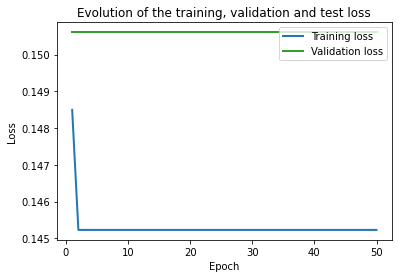

Computing standard benchmark p-values for 500 test points...
Calibrating each model in the list...


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


RuntimeError: Error(s) in loading state_dict for ConvAutoencoder:
	Missing key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "t_conv1.weight", "t_conv1.bias", "t_conv2.weight", "t_conv2.bias". 
	Unexpected key(s) in state_dict: "base_model.0.weight", "base_model.0.bias", "base_model.2.weight", "base_model.2.bias". 

In [8]:
# Initialize result data frame
results = pd.DataFrame({})

# Define the experiment parameters
n_train_bm = 100
n_val_bm = 100
n_cal_bm = 100
n_test = 500
lr = 1
n_epoch = 50
alpha_list = [0.1]
num_repetitions = 10

def add_header(df):
    df["n_epoch"] = n_epoch
    df["n_calib"] = n_cal_bm
    return df

for r in range(num_repetitions):
    print("\nStarting repetition {:d} of {:d}:\n".format(r+1, num_repetitions))
    sys.stdout.flush()
    
    # Change random seed for this repetition
    seed = r
    results_new = run_experiment(seed, n_train_bm, n_val_bm, n_cal_bm, n_test, lr, n_epoch, alpha_list)
#     results_new = add_header(results_new)
    results_new["Repetition"] = r
    results = pd.concat([results, results_new])

In [ ]:
results

In [ ]:
sb_results = results[results["Method"]=="Standard benchmark"]

In [ ]:
nb_results = results[results["Method"]=="Naive benchmark"]

In [ ]:
print("The standard benchmark FPR is: {:.6f}, TPR is:{:.6f}".format(np.sum(sb_results["Fixed-FPR"])/num_repetitions, 
                                                     np.sum(sb_results["Fixed-TPR"])/num_repetitions))


In [ ]:
print("The naive benchmark FPR is: {:.6f}, TPR is:{:.6f}".format(np.sum(nb_results["Fixed-FPR"])/num_repetitions,
                                                  np.sum(nb_results["Fixed-TPR"])/num_repetitions))

In [ ]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(y="Fixed-FPR", x="Method", hue="Method", data=results, ax=ax1)
ax1.set(xlabel='Method', ylabel='FPR')
ax1.axhline(alpha_list[0], ls='--', color="red")
ax1.legend(loc='upper center', title='Method')

sns.boxplot(y="Fixed-TPR", x="Method", hue="Method", data=results, ax=ax2)
ax2.set(xlabel='Method', ylabel='TPR')
ax2.legend(loc='upper center', title='Method')
plt.show()

In [ ]:
# Store the results dataframe
from pathlib import Path
results_dir = "./results/"
Path(results_dir).mkdir(parents=True, exist_ok=True)
results.to_csv(results_dir+'OD_results.csv')